**Author:** Erik Weis <br>
**Date:** 2025-06-24 <br>
**Contact:** weis.er@northeastern.edu <br>
**Code:** [this repository](https://github.com/erikweis/graph-tool-MDL-tutorial)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import graph_tool.all as gt
import networkx as nx
from time import time

%matplotlib inline

# Introduction to `graph-tool`

Graph-tool is a powerful library for analyzing networks, plus more.
Most importantly, it is fast and efficient because it is writtine in C++, with a python wrapper.
While the python interface is convenient, all the heavy computation is done in C++.

This software architecture speed makes the python interface slightly more complicated, when it comes to manipulating graphs and their properties.
If you are new to network science and not working with analyzing large networks, you might want to start with `networkx`.
However, if you are dealing with large networks, `graph-tool` is a great choice, and my go-to library for analyzing networks.

### Installation

We'll assume that you have `graph-tool` installed.
If you don't, you can find instructions on the [graph-tool website](https://graph-tool.skewed.de/static/docs/stable/index.html#installing-graph-tool).
Using `conda` is by far the easiest installation method, and as mentioned in the installation instructions, it's best to create a new environment for it. I've found that `graph-tool` doesn't always work properly when installed to existing Conda environments.

# Graph basics

Let's start by initializating a graph, and note that graphs are **directed by default**!

In [2]:
g = gt.Graph(directed=False)

Now let's add some edges to the graph.

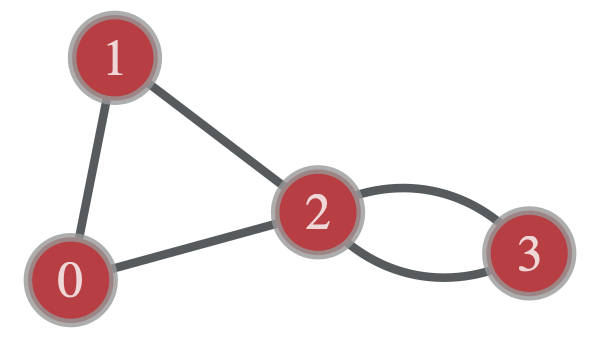

In [3]:
edge_list = [(0,1),(0,2),(1,2),(2,3),(2,3)]
g.add_edge_list(edge_list)
np.random.seed(42)
gt.seed_rng(1)
gt.graph_draw(g, output_size=(300,300), vertex_text = g.new_vertex_property("string", [str(v) for v in g.vertices()]));

Note that the graph is by default a **multigraph**, meaning that multiple edges between the same pair of nodes are allowed.
Thus, adding the same edge twice will add an additional edge, which is not the case in `networkx`.

Note that this is qualitatively different from edge **weights**, which we can add to the network in a different way.

In [4]:
weighted_edge_list = [(i,j,np.random.randint(1,10)) for i,j in edge_list]
g_w = gt.Graph(directed=False)
g_w.add_edge_list(weighted_edge_list, eprops=[("weight","int")])

What happened here? We added a random integer weight to each edge in the graph and passed this weighted edgelist into the edgelist function.
The `eprops` argument creates something called an `EdgePropertyMap`, which we'll discuss in the next section.

There's a bunch of other ways to construct graphs for convnenience, and you can check out the [quick-start guide](https://graph-tool.skewed.de/static/docs/stable/quickstart.html#graph-i-o) for more info.

# Graph data

If you're just exploring the algorithms and looking for data, `graph-tool` has some built in networks to play around with.

In [5]:
np.array(list(gt.collection.data.keys()))

array(['adjnoun', 'as-22july06', 'astro-ph', 'celegansneural', 'cond-mat',
       'cond-mat-2003', 'cond-mat-2005', 'dolphins', 'email-Enron',
       'football', 'hep-th', 'karate', 'lesmis', 'netscience',
       'pgp-strong-2009', 'polblogs', 'polbooks', 'power',
       'serengeti-foodweb'], dtype='<U17')

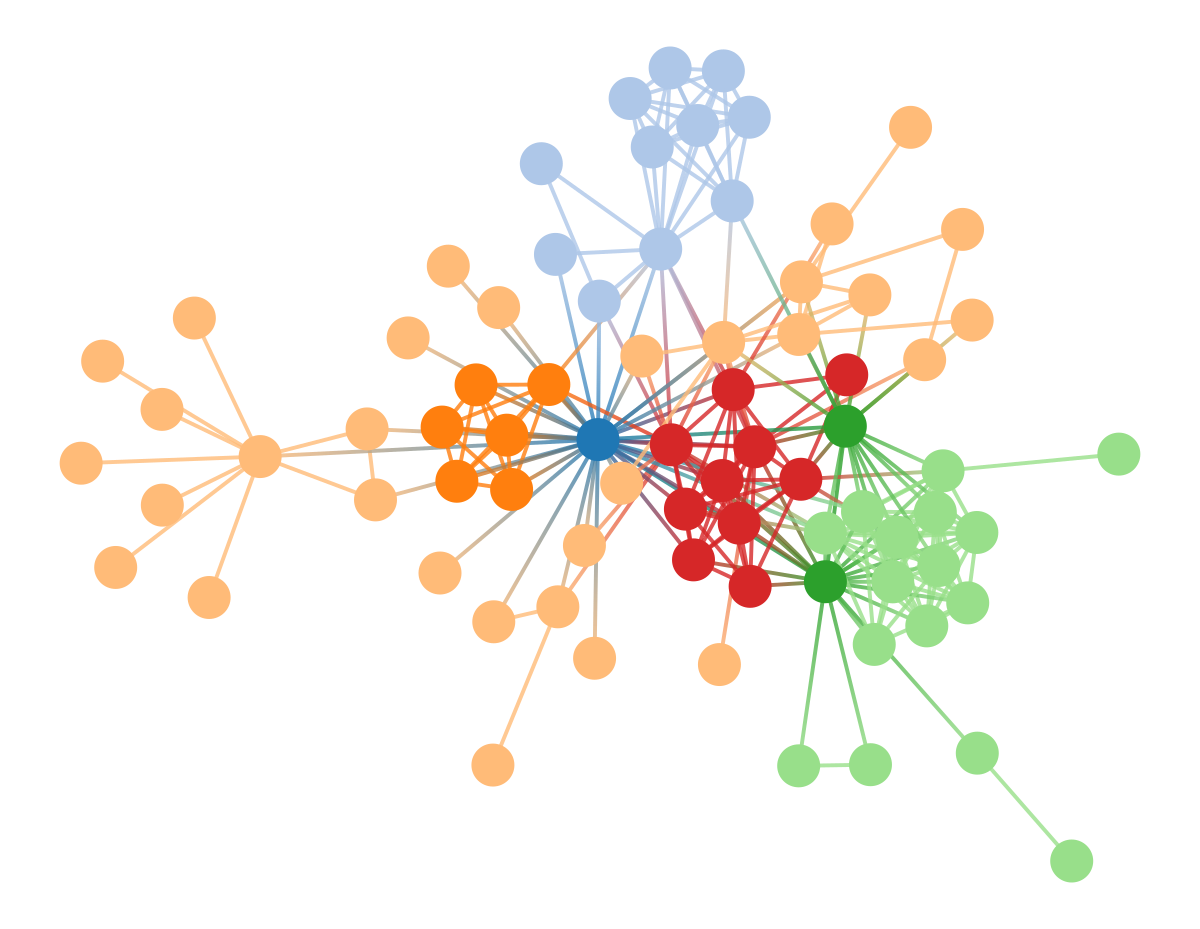

In [6]:
# load the Les Miserables co-occurance graph
g  = gt.collection.data['lesmis']
# Run community detection
np.random.seed(7)
gt.minimize_blockmodel_dl(g).draw();

Another useful feature of `graph-tool` is its connection to the Netzschleuder library, which has a huge collection of commonly used and obscure network datasets.

For example, here's a dataset of the Chicago road network, with $E = 39,018$ roads and $N= 12,982$ intersections.

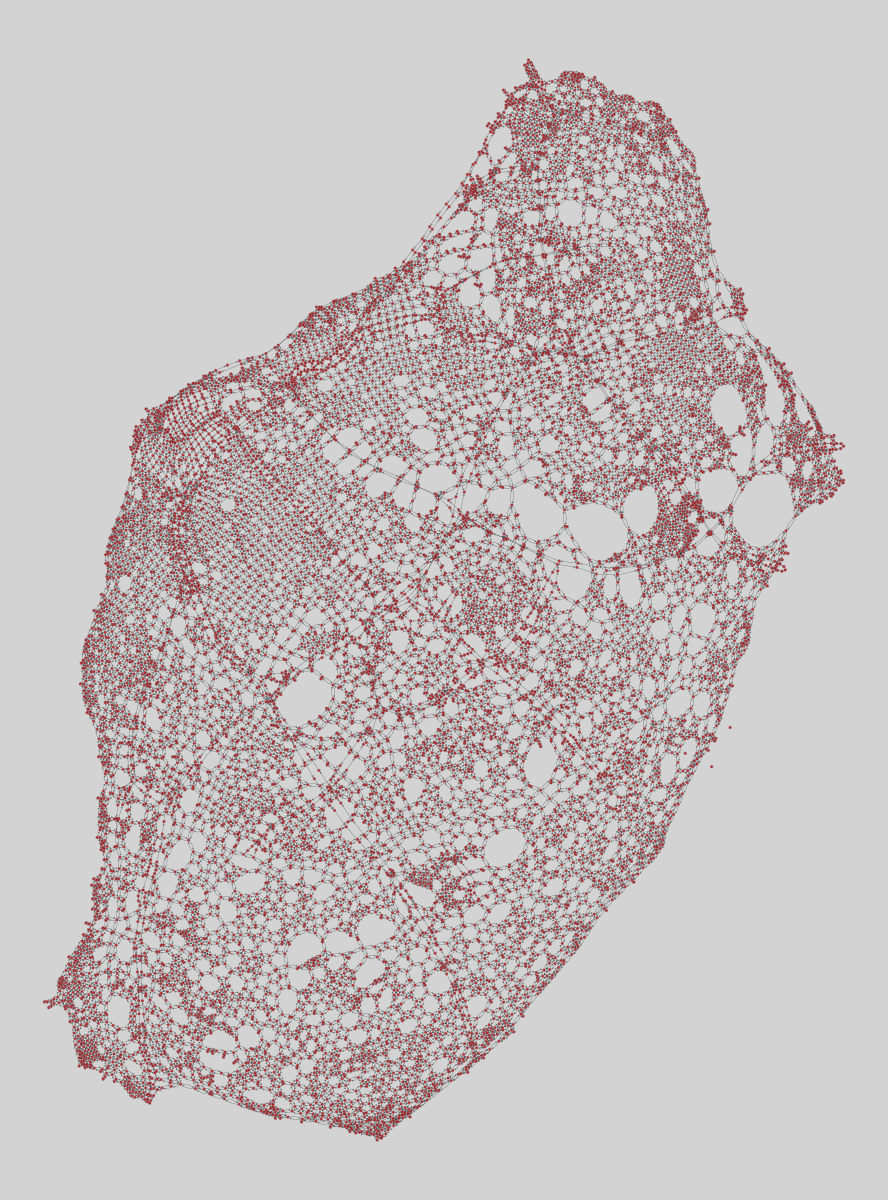

In [7]:
g = gt.collection.ns['chicago_road']
# draw the graph, using the saved positions of the intersections
gt.graph_draw(g,pos = g.vp['_pos'], bg_color='lightgrey');

# Property maps

Property maps are largely an artifact of the fact that `graph-tool` is written in C++.
These property maps facilitatte the connection between the C++ and Python interfaces.
While they add an extra layer of complexity, they're not so complicated once you get used to them and actually quite convenient.

Essentially, property maps are used to track any extra data we want to store on the nodes (`VertexPropertyMap`) and edges (`EdgePropertyMap`).

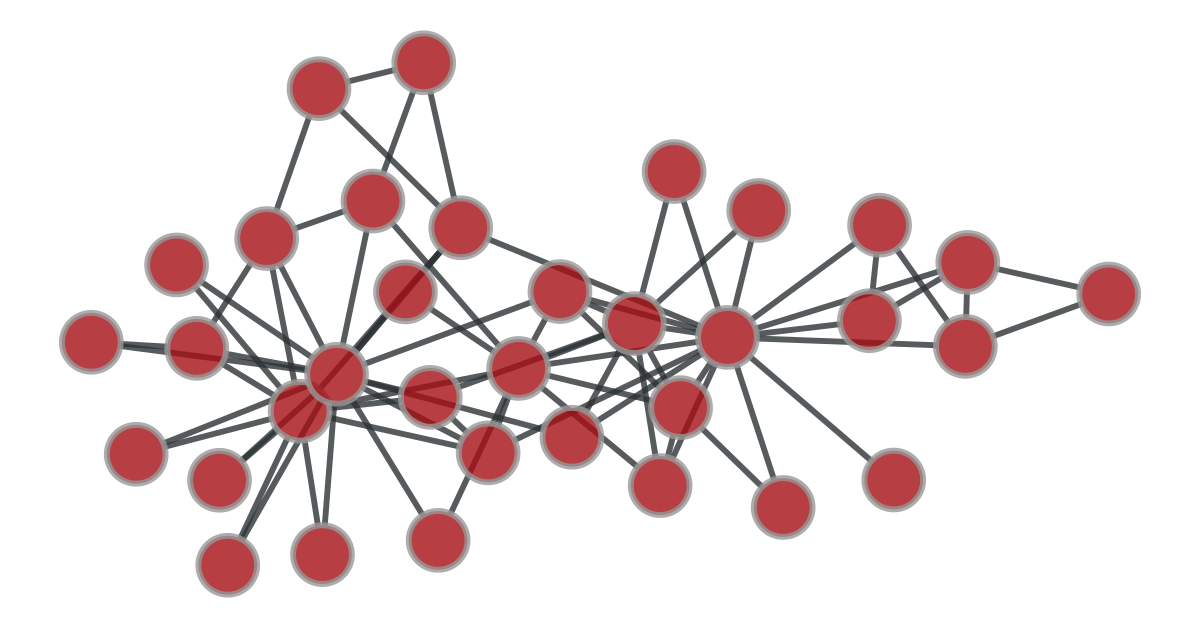

In [8]:
g = gt.collection.data['karate']
np.random.seed(2)
gt.graph_draw(g);

## Vertex Property Maps

Let's start look at some examples of vertex property maps. Each property map has an underlying array, which is used to store the data on both the python/C++ side.

In [9]:
degrees = g.degree_property_map("total")
# each property map object has a PropertyArray
a = degrees.get_array()
# equivalently
a = degrees.a
a

PropertyArray([16,  9, 10,  6,  3,  4,  4,  4,  5,  2,  3,  1,  2,  5,  2,
                2,  2,  2,  2,  3,  2,  2,  2,  5,  3,  3,  2,  4,  3,  4,
                4,  6, 12, 17], dtype=int32)

In [10]:
# compute the betweenness centrality for both nodes and edges
betweenness_nodes, betweenness_edges = gt.betweenness(g)
betweenness_nodes.a

PropertyArray([0.43763528, 0.05393669, 0.14365681, 0.01190927, 0.00063131,
               0.02998737, 0.02998737, 0.        , 0.05592683, 0.00084776,
               0.00063131, 0.        , 0.        , 0.0458634 , 0.        ,
               0.        , 0.        , 0.        , 0.        , 0.03247505,
               0.        , 0.        , 0.        , 0.01761364, 0.0022096 ,
               0.00384049, 0.        , 0.02233345, 0.00179473, 0.00292208,
               0.01441198, 0.13827561, 0.14524711, 0.30407498])

In [11]:
pos = gt.sfdp_layout(g) # spring layout
print("pos has type:", type(pos))
pos.get_2d_array()

pos has type: <class 'graph_tool.VertexPropertyMap'>


array([[ 8.52932964,  7.22029978,  5.38444142,  8.17357422, 10.43632764,
        12.00736106, 10.68828773,  7.29123457,  4.57928415,  3.92671046,
        11.87687102, 11.89401821,  9.89777732,  6.08438556, -0.1110655 ,
         1.02745202, 12.89265464,  9.90378687, -0.12002637,  6.20163177,
        -0.62652236,  8.19380991,  1.81898662,  1.47328772,  4.22900544,
         2.46231256, -1.49158357,  3.23366713,  3.54102871,  0.11964769,
         3.8939757 ,  4.58058885,  1.67002181,  2.51261876],
       [ 2.98667077,  3.74886278,  3.85974822,  5.08301969,  1.56396457,
         0.83694677, -0.1753404 ,  6.01219243,  3.10459222,  6.43743302,
         2.61895739,  4.7882104 ,  6.17692418,  4.99203621,  5.89390687,
         5.01226805, -1.2855028 ,  4.17094362,  1.17699458,  2.10824494,
         4.26959783,  1.05261893,  6.3583036 ,  0.85362768, -1.68179693,
        -1.47096003,  2.72806388,  0.65288274,  2.08470846,  2.4928962 ,
         4.68933953,  0.97628927,  3.44906212,  3.4305542 ]])

### Defining new property maps

Defining a new property map is easy, but requires specifying a data type. This is necessary because the C++ interface needs to know what kind of data it is dealing with. Here, we'll define a property map for the vertex names, which are type `string`, but the other options are `double` (aka a float) or `int`.

In [12]:
# Defining a new vertex property map
affinity = g.new_vertex_property("string")
affinity.set_values(["Mr. Hi" if i < 17 else "John A" for i in range(g.num_vertices())])
affinity[3]

'Mr. Hi'

By the way, it's not possible to access the array of a "string" property map directly using the 'get_array' method, so we have to use the `get` method instead.

In [13]:
a = [affinity[i] for i in range(g.num_vertices())]
print(a)

['Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'Mr. Hi', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A', 'John A']


## Edge property maps

In [14]:
weights = g.new_edge_property("double")
weights.a = np.random.rand(g.num_edges())
weights.a

PropertyArray([0.84511312, 0.9885097 , 0.04886809, 0.23211825, 0.64331143,
               0.16146656, 0.87014589, 0.21740243, 0.74175504, 0.65302051,
               0.79888551, 0.03124756, 0.22957403, 0.7046275 , 0.08756251,
               0.03058948, 0.35713493, 0.58978199, 0.05222273, 0.06566367,
               0.04350119, 0.39515076, 0.66842705, 0.19802711, 0.87626645,
               0.4323891 , 0.61964146, 0.29042674, 0.61525457, 0.95365996,
               0.44801472, 0.20704984, 0.42536729, 0.44457426, 0.50761749,
               0.52573325, 0.04242919, 0.16441909, 0.45022718, 0.70797117,
               0.77758791, 0.777103  , 0.50277875, 0.95674759, 0.33187371,
               0.48145816, 0.748374  , 0.85783952, 0.41446006, 0.84868451,
               0.44457094, 0.71574708, 0.00844836, 0.02520142, 0.94045049,
               0.10213795, 0.66196779, 0.28325874, 0.20084234, 0.38833418,
               0.9259016 , 0.57027421, 0.91671461, 0.70226424, 0.50121645,
               0.50608683

# A brief performance benchmark 

In [ ]:
import networkx as nx

# create a random graph using NetworkX and graph-tool
G = nx.erdos_renyi_graph(10000, 0.01, seed=42)
g = gt.Graph(directed=False)
g.add_edge_list(G.edges())

# compute all shortest path lengths
start = time()
sp = gt.shortest_distance(g, source=0, target=None, weights=None)
print("Graph-tool shortest path computation took", time() - start, "seconds")
start = time()
sp_nx = dict(nx.all_pairs_shortest_path_length(G)) #should take about 20seconds
print("NetworkX shortest path computation took", time() - start, "seconds")

Graph-tool shortest path computation took 0.002440214157104492 seconds
NetworkX shortest path computation took 21.851876974105835 seconds


As we can see, `graph-tool` is very fast. If you're willing to wait, try 50,000 nodes and see the difference more starkly.

# Community detection

Once your graph is loaded into graph-tool, you can use the built-in community detection algorithms to find communities in your network.

In [26]:
g = gt.collection.ns["facebook_organizations/M1"]

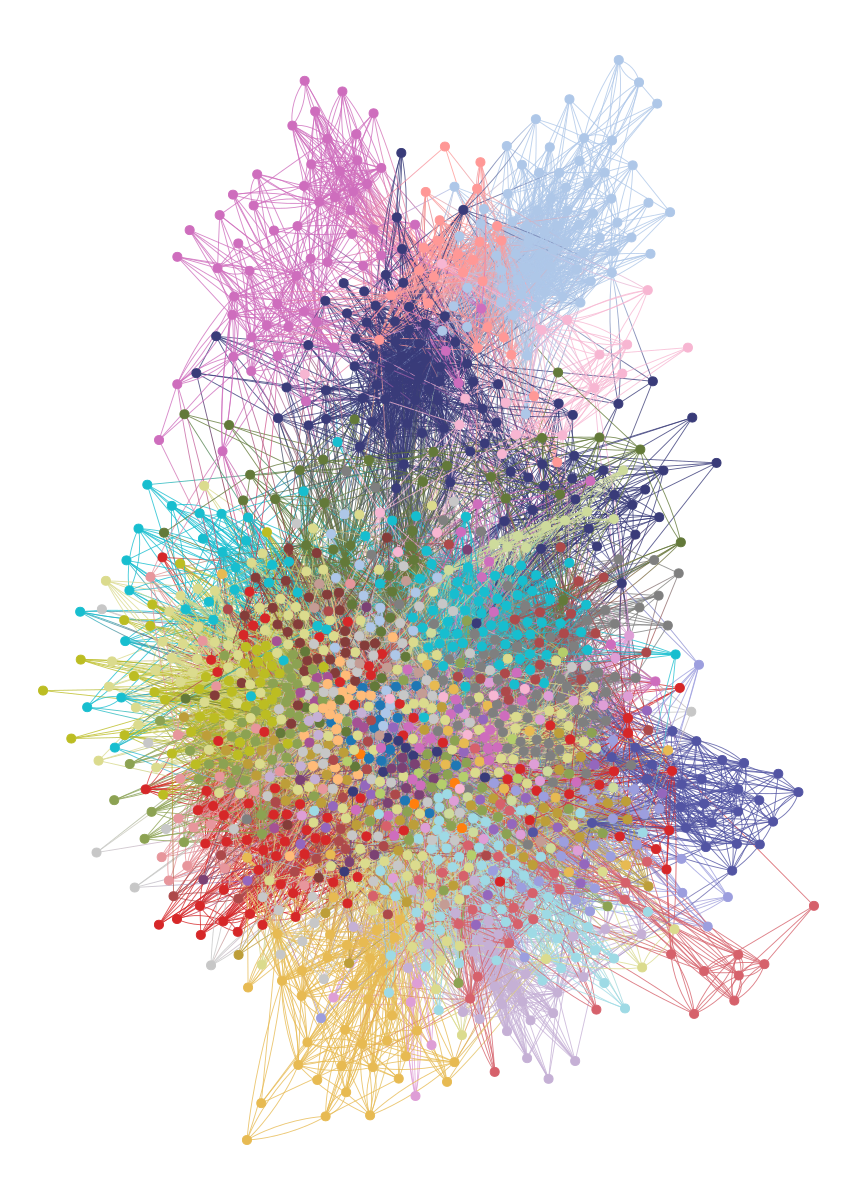

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3092be8a0, at 0x3092fc050>

In [ ]:
state = gt.minimize_blockmodel_dl(g)
state.draw();

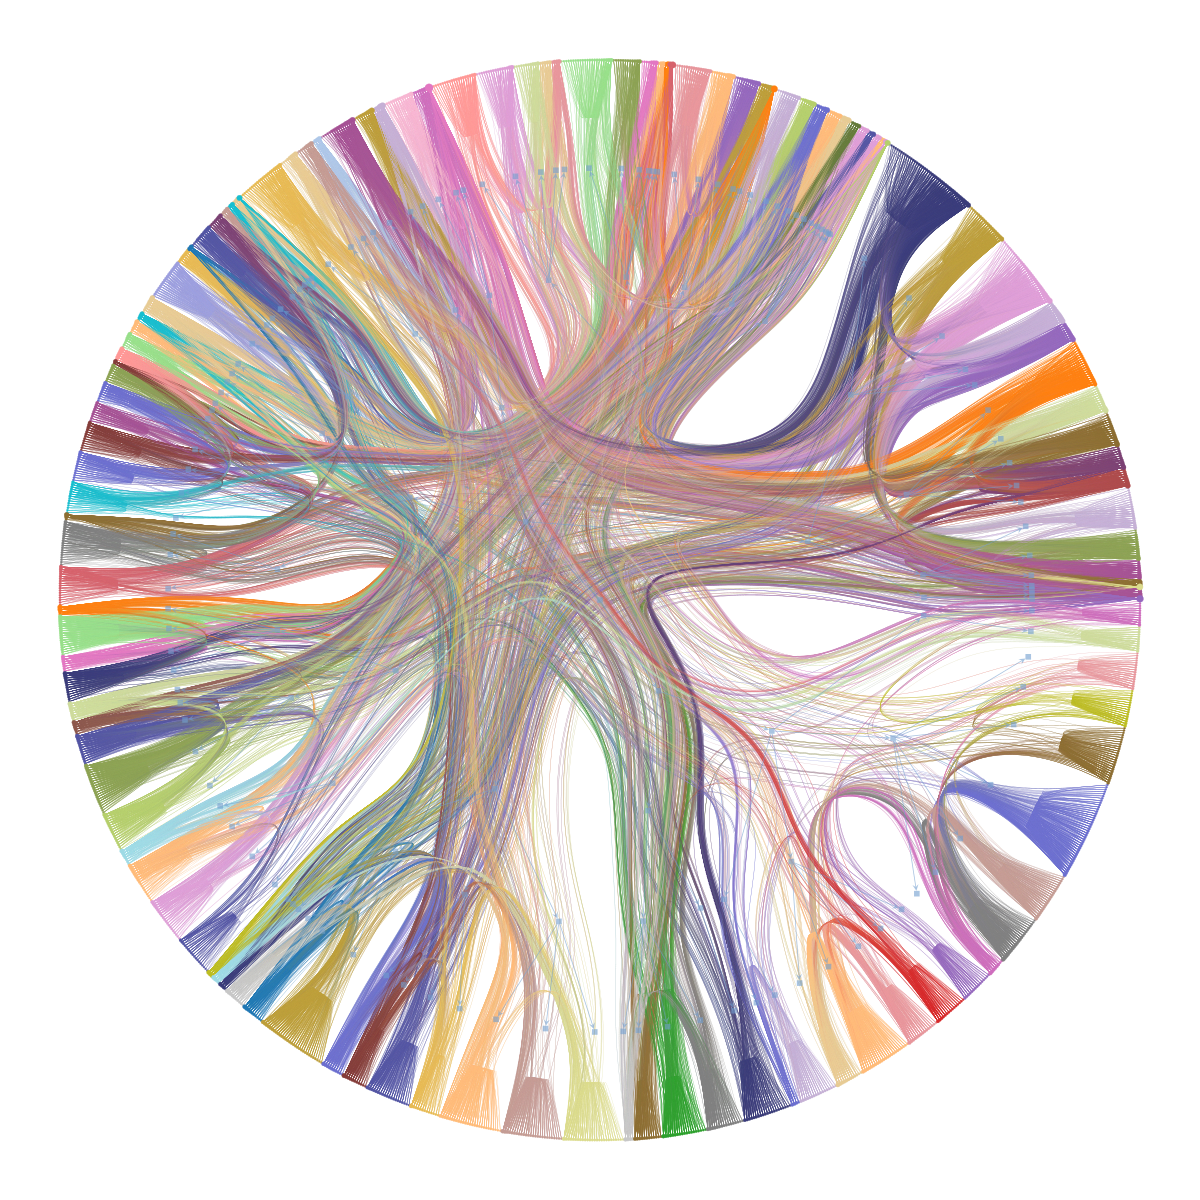

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3092be8a0, at 0x31c361a30>,
 <GraphView object, directed, with 1596 vertices and 1595 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x31c3aa870, at 0x31c3aa8d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x31c3aa870, at 0x31c3afe60>, False), at 0x31c3aa870>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x31c3aa870, at 0x31c3afda0>)

In [ ]:
state = gt.minimize_nested_blockmodel_dl(g)
state.draw();

The community structure is store in a `VertexPropertyMap`, accesible like this:

In [35]:
communities = state.get_levels()[0].b.a.tolist()
communities

[897,
 107,
 1288,
 434,
 1299,
 654,
 738,
 641,
 950,
 142,
 1179,
 296,
 1236,
 638,
 308,
 962,
 142,
 440,
 897,
 92,
 653,
 308,
 1113,
 1179,
 107,
 308,
 1032,
 765,
 1392,
 1113,
 434,
 1113,
 469,
 653,
 974,
 1299,
 1341,
 765,
 1113,
 641,
 1179,
 303,
 950,
 1341,
 142,
 348,
 897,
 434,
 434,
 1236,
 565,
 434,
 33,
 469,
 1179,
 790,
 790,
 790,
 790,
 507,
 790,
 790,
 790,
 790,
 790,
 790,
 732,
 1247,
 1370,
 579,
 1299,
 732,
 732,
 38,
 690,
 1129,
 732,
 732,
 579,
 1380,
 962,
 1370,
 732,
 1346,
 995,
 995,
 995,
 1380,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 995,
 1380,
 995,
 722,
 722,
 722,
 722,
 722,
 1348,
 722,
 722,
 1045,
 722,
 407,
 507,
 747,
 407,
 507,
 407,
 747,
 747,
 1032,
 596,
 323,
 1032,
 1032,
 90,
 323,
 1032,
 1032,
 1032,
 1032,
 1032,
 1348,
 889,
 1032,
 889,
 1179,
 323,
 1001,
 947,
 947,
 995,
 371,
 738,
 708,
 1142,
 419,
 1275,
 1117,
 747,
 738,
 1,
 747,
 142,
 308,
 1002,
 747,
 1416,
 213,
 347,
 1117,
 1117,